In [1]:
import pandas as pd

### Model Training

In [2]:
df = pd.read_csv('./data/titanic-train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# data preparation - use only useful fields
final_df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
final_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,male,22.0,1,0,7.2500,0
1,1,female,38.0,1,0,71.2833,1
2,3,female,26.0,0,0,7.9250,1
3,1,female,35.0,1,0,53.1000,1
4,3,male,35.0,0,0,8.0500,0


In [4]:
from scipy import stats

# replace outliers from Fare data
final_df.loc[final_df['Fare'] >= 100, 'Fare'] = 100

# transform Fare column to convert to normal distribution
final_df['Fare_Transform'], _ = stats.boxcox(final_df['Fare'] + 0.5)
final_df

C:\Users\USER\AppData\Local\Temp\ipykernel_11076\108932973.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Fare_Transform'], _ = stats.boxcox(final_df['Fare'] + 0.5)


,Pclass,Sex,Age,SibSp,Parch,Fare,Survived,Fare_Transform
0,3,male,22.0,1,0,7.2500,0,2.218672
1,1,female,38.0,1,0,71.2833,1,5.064247
2,3,female,26.0,0,0,7.9250,1,2.316823
3,1,female,35.0,1,0,53.1000,1,4.662339
4,3,male,35.0,0,0,8.0500,0,2.334198
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,0,2.883012
887,1,female,19.0,0,0,30.0000,1,3.911773
888,3,female,NaN,1,2,23.4500,0,3.599829
889,1,male,26.0,0,0,30.0000,1,3.911773


In [5]:
X = final_df.drop(['Survived', 'Fare'], axis=1)
y = final_df['Survived']

In [6]:
## segregate numerical and categorical columns
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols = X.select_dtypes(include='object').columns

print("Numerical columns:",numerical_cols)
print('Categorical Columns:',categorical_cols)

Numerical columns: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare_Transform'], dtype='object')
Categorical Columns: Index(['Sex'], dtype='object')


In [7]:
# verify no. of category for each ordinal variable
print(X['Sex'].unique().tolist())

['male', 'female']


In [8]:
# Define the custom ranking for each ordinal variable
sex_categories = ['male', 'female']

In [9]:
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [10]:
# Numerical Pipeline
num_pipeline=Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ]
)

# Categorigal Pipeline
cat_pipeline=Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder(categories=[sex_categories])),
    ('scaler', StandardScaler())
    ]
)

# Preprocessor
preprocessor=ColumnTransformer([
('num_pipeline', num_pipeline, numerical_cols),
('cat_pipeline', cat_pipeline, categorical_cols)
])


In [11]:
## Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [12]:
# check imbalance in the training data
y_0 = y_train[y_train == 0]
y_1 = y_train[y_train == 1]
print(len(y_0), len(y_1))

389 234


In [14]:
### dataset is imbalanced because class 0 is about 1.5 time of class 1

In [13]:
# up sampling to balance the dataset
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train2, y_train2 = ros.fit_resample(X_train, y_train)

In [14]:
# check data counts now
y_0 = y_train2[y_train2 == 0]
y_1 = y_train2[y_train2 == 1]
print(len(y_0), len(y_1))

389 389


In [15]:
# apply preprocessor
X_train2 = pd.DataFrame(preprocessor.fit_transform(X_train2), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [16]:
X_train2.head()

,num_pipeline__Pclass,num_pipeline__Age,num_pipeline__SibSp,num_pipeline__Parch,num_pipeline__Fare_Transform,cat_pipeline__Sex
0,-1.491520,1.438762,-0.481737,-0.491782,0.322174,1.180613
1,0.859853,-0.222836,0.496830,-0.491782,-0.876396,-0.847018
2,0.859853,0.872308,-0.481737,-0.491782,-0.888879,-0.847018
3,-0.315834,-0.373891,-0.481737,-0.491782,-0.599695,-0.847018
4,-0.315834,0.532435,0.496830,-0.491782,0.325084,1.180613


In [17]:
X_test.head()

,num_pipeline__Pclass,num_pipeline__Age,num_pipeline__SibSp,num_pipeline__Parch,num_pipeline__Fare_Transform,cat_pipeline__Sex
0,-0.315834,-0.827054,-0.481737,2.058928,-0.389877,1.180613
1,-1.491520,-0.902581,0.496830,-0.491782,1.852673,1.180613
2,0.859853,-0.071782,-0.481737,-0.491782,-0.853323,-0.847018
3,-1.491520,0.759017,0.496830,-0.491782,1.171293,1.180613
4,-0.315834,2.345088,0.496830,0.783573,0.766109,-0.847018


In [18]:
## Model training
from sklearn.tree import DecisionTreeClassifier

# instantiate a decision tree classifier model and fit with X_train2 and y_train2 data
model = DecisionTreeClassifier()
model.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [19]:
## Evaluate model
from sklearn.metrics import accuracy_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train2)

print("train set accuracy score: ", accuracy_score(y_train2, y_pred_train))
print("test set accuracy score :",  accuracy_score(y_test, y_pred_test))

train set accuracy score:  0.9922879177377892
test set accuracy score : 0.7761194029850746


In [20]:
# Perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV

grid_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 30, 1),
    'min_samples_split': range(2,10,1),
    'min_samples_leaf': range(1,10,1)
}

# initializing grid-search-cv
clf = DecisionTreeClassifier()
clf_grid = GridSearchCV(estimator=clf, param_grid=grid_params, cv=5, n_jobs=-1, verbose=3)
clf_grid.fit(X_train2, y_train2)

Fitting 5 folds for each of 8352 candidates, totalling 41760 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']},
             verbose=3)

In [21]:
# best score and parameter for the model
print(clf_grid.best_score_)
print(clf_grid.best_params_)

0.8767493796526054
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


In [67]:
from sklearn.metrics import confusion_matrix

# fitting the model with the above parameters
# gridsearch_best_params = {'criterion': 'entropy', 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
gridsearch_best_params = {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
model2 = DecisionTreeClassifier(**gridsearch_best_params)
model2.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=20, splitter='random')

In [68]:
print('train score = ', model2.score(X_train2, y_train2))
print('test score = ', model2.score(X_test, y_test))

train score =  0.9858611825192802
test score =  0.7985074626865671


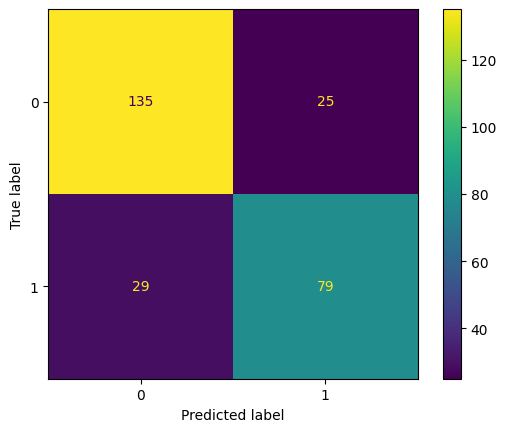

In [69]:
# plot_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_test = model2.predict(X_test)

labels = list(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [70]:
# print accuracy results
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1_score = 2*precision*recall/(precision+recall)

print("accuracy = ", round(accuracy, 2))
print("recall = ", round(recall, 2))
print("precision = ", round(precision, 2))
print("F1_score = ", round(f1_score, 2))

accuracy =  0.8
recall =  0.82
precision =  0.84
F1_score =  0.83


In [71]:
# classification report
# Finding Precision, Recall, F1- Score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.82      0.84      0.83       160
    Survived       0.76      0.73      0.75       108

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268



AUC = 0.7876157407407407


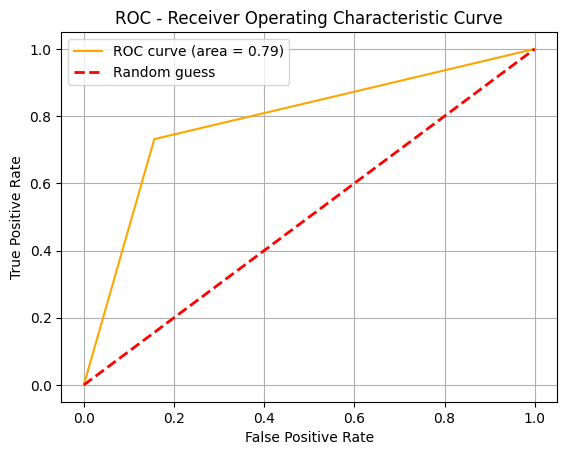

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculating area under curve
# The  AUC represents the area under the ROC curve
auc = roc_auc_score(y_test, y_pred_test)
print(f'AUC = {auc}')

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)

# plot
plt.plot(false_positive_rate, true_positive_rate, color='orange', label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Receiver Operating Characteristic Curve')
plt.grid()
plt.legend()
plt.show()

[Text(0.5528693181818182, 0.9761904761904762, 'x[5] <= -0.078\ngini = 0.5\nsamples = 778\nvalue = [389, 389]'),
 Text(0.29210227272727274, 0.9285714285714286, 'x[0] <= -1.185\ngini = 0.389\nsamples = 453\nvalue = [333, 120]'),
 Text(0.11818181818181818, 0.8809523809523809, 'x[1] <= -0.865\ngini = 0.5\nsamples = 97\nvalue = [49, 48]'),
 Text(0.11090909090909092, 0.8333333333333334, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.12545454545454546, 0.8333333333333334, 'x[4] <= 0.994\ngini = 0.5\nsamples = 95\nvalue = [49, 46]'),
 Text(0.08181818181818182, 0.7857142857142857, 'x[4] <= 0.334\ngini = 0.499\nsamples = 61\nvalue = [29, 32]'),
 Text(0.07454545454545454, 0.7380952380952381, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.0890909090909091, 0.7380952380952381, 'x[1] <= 2.287\ngini = 0.483\nsamples = 54\nvalue = [22, 32]'),
 Text(0.08181818181818182, 0.6904761904761905, 'x[1] <= 2.101\ngini = 0.461\nsamples = 50\nvalue = [18, 32]'),
 Text(0.07454545454545454, 0.64285714285

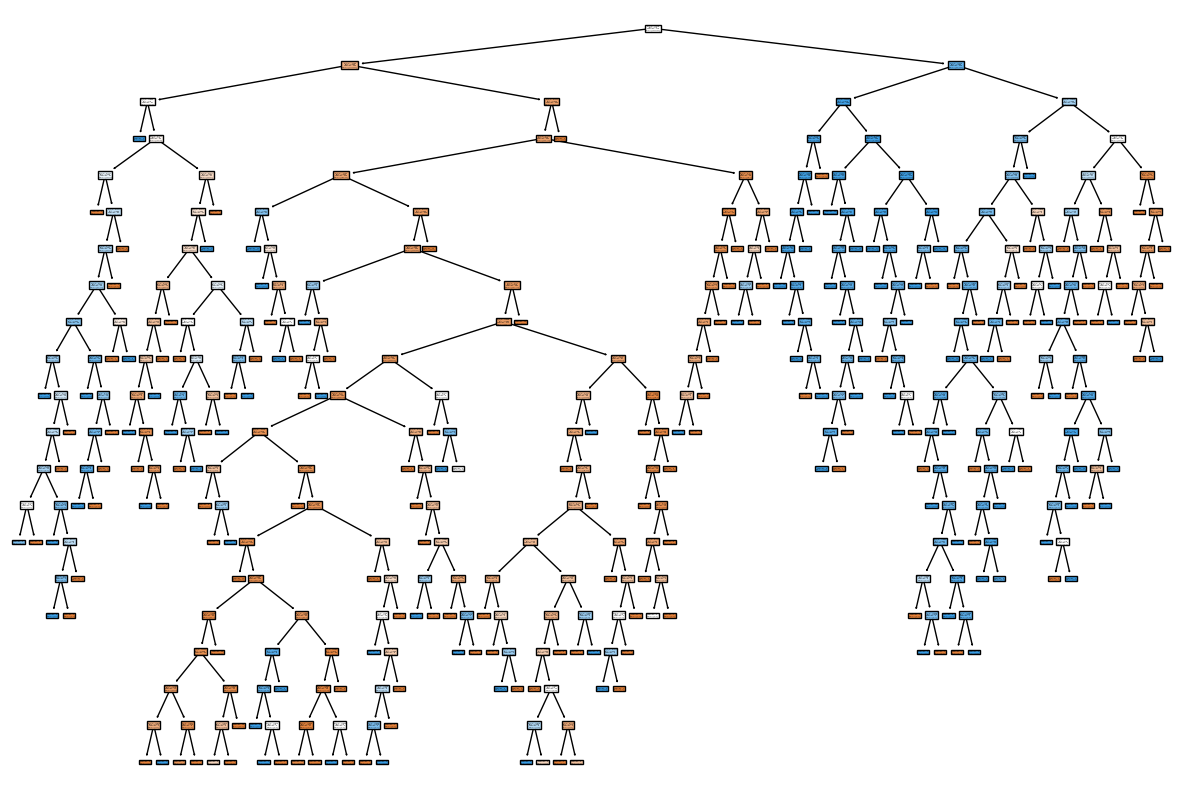

In [73]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(model2, filled=True)

In [74]:
from sklearn.model_selection import cross_val_score

prediction = cross_val_score(model2, X_train2, y_train2, cv=10)

prediction

array([0.83333333, 0.83333333, 0.83333333, 0.78205128, 0.79487179,
       0.75641026, 0.93589744, 0.96153846, 0.94805195, 0.88311688])

In [75]:
import numpy as np

np.mean(prediction)

0.8561938061938061